In [38]:
import boto3
import io
import constants
import pickle
import matplotlib.pyplot as plt
import torch


In [32]:
def get_loss_from_run(run_name):
    s3 = boto3.client("s3")
    response = s3.get_object(Bucket = constants.BUCKET_NAME, Key = f"Runs/{run_name}/loss.pickle")
    buffer = io.BytesIO(response["Body"].read())
    data = torch.load(buffer)
    return data


In [22]:
def get_epoch_images(run_name, epoch):
    s3 = boto3.client("s3")
    data = s3.get_object(Bucket = constants.BUCKET_NAME, Key = f"Runs/{run_name}/{epoch}/data.pt")
    buffer = io.BytesIO(data["Body"].read())
    data = torch.load(buffer)

    targets = s3.get_object(Bucket = constants.BUCKET_NAME, Key = f"Runs/{run_name}/{epoch}/targets.pt")
    buffer = io.BytesIO(targets["Body"].read())
    targets = torch.load(buffer)

    predictions = s3.get_object(Bucket = constants.BUCKET_NAME, Key = f"Runs/{run_name}/{epoch}/predictions.pt")
    buffer = io.BytesIO(predictions["Body"].read())
    predictions = torch.load(buffer)
    return {
        "data" : data.to("cpu"),
        "targets": targets.to("cpu"),
        "predictions": predictions.to("cpu")
    }

In [27]:
epoch_data = get_epoch_images("03-30_03:20:45", 1)


In [37]:
thresh = torch.nn.Threshold(0.5, 1)
thresh(epoch_data["predictions"][13])

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], grad_fn=<ThresholdBackward0>)

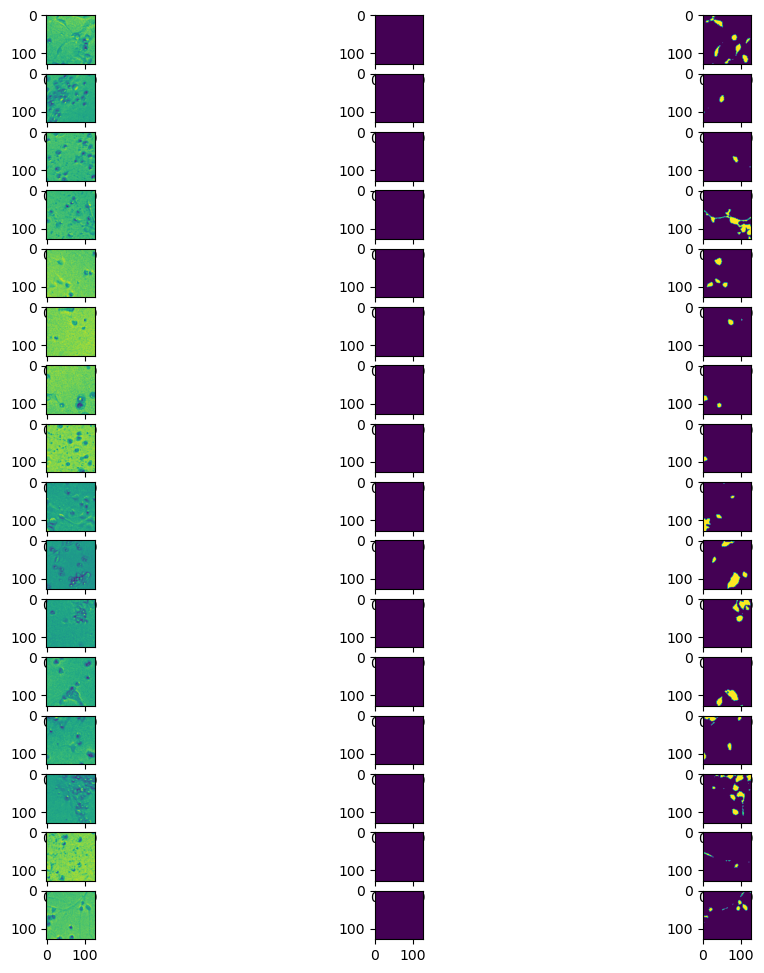

In [28]:
fig, ax = plt.subplots(nrows = epoch_data["data"].shape[0], ncols=3, figsize = (12, 12))
for i in range(epoch_data["data"].shape[0]):
    data = epoch_data["data"][i].squeeze()
    pred = epoch_data["predictions"][i].squeeze().detach().to(torch.float32).numpy()
    target = epoch_data["targets"][i].squeeze()
    ax[i][0].imshow(data)
    ax[i][1].imshow(pred)
    ax[i][2].imshow(target)
plt.show()

In [53]:
prediction = epoch_data["predictions"][4].squeeze()
torch.save(prediction, "prediction.pt")

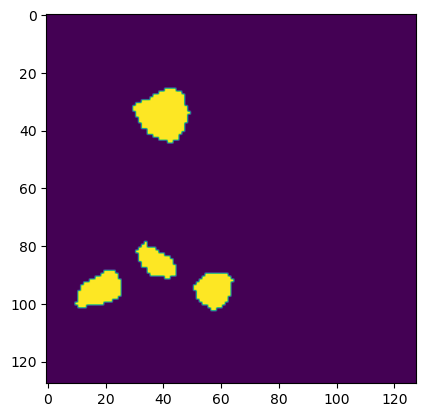

In [52]:
val = epoch_data["targets"][4].squeeze()
torch.save(val, "val.pt")
plt.imshow(val)

In [33]:
loss_data = get_loss_from_run("03-30_03:20:45")

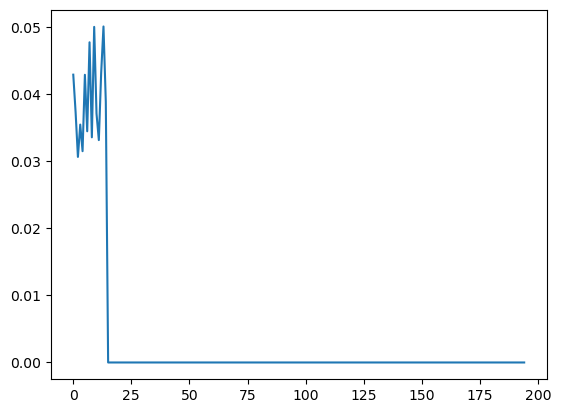

In [34]:
plt.plot(loss_data)

In [57]:
last_batch_dict = torch.load("last_batch_dict.pt")


dict_keys(['data', 'predictions', 'targets'])


In [58]:
last_batch_dict["data"].shape

torch.Size([4, 1, 128, 128])

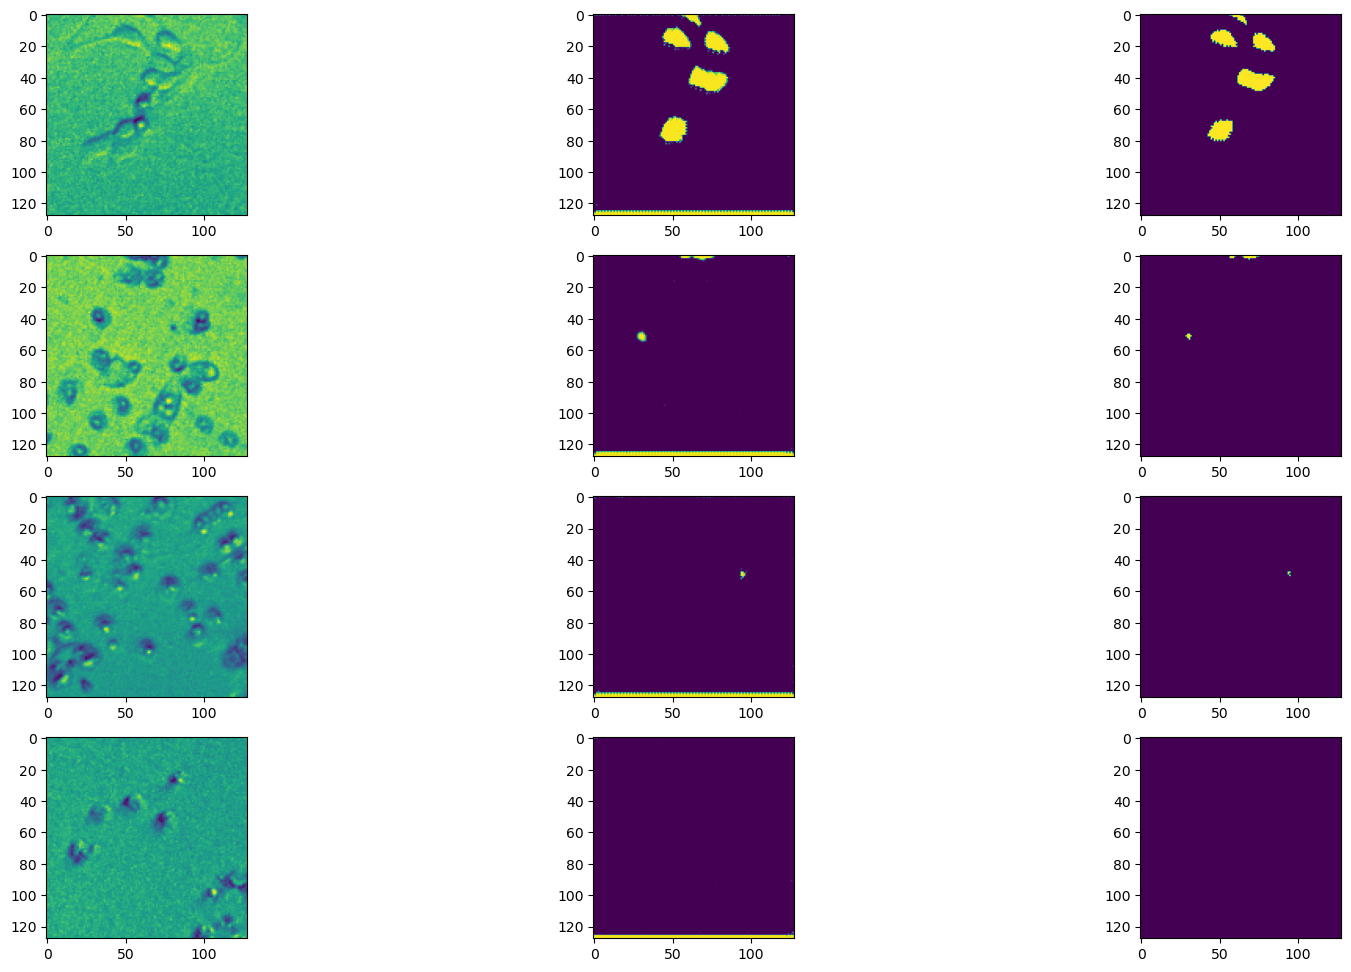

In [61]:
fig, ax = plt.subplots(nrows = last_batch_dict["data"].shape[0], ncols = 3, figsize = (20, 12))
for i in range(last_batch_dict["data"].shape[0]):
    data = last_batch_dict["data"][i].to("cpu").squeeze()
    pred = last_batch_dict["predictions"][i].to("cpu").squeeze().detach().to(torch.float32).numpy()
    target = last_batch_dict["targets"][i].to("cpu").squeeze()
    ax[i][0].imshow(data)
    ax[i][1].imshow(pred)
    ax[i][2].imshow(target)
plt.show()

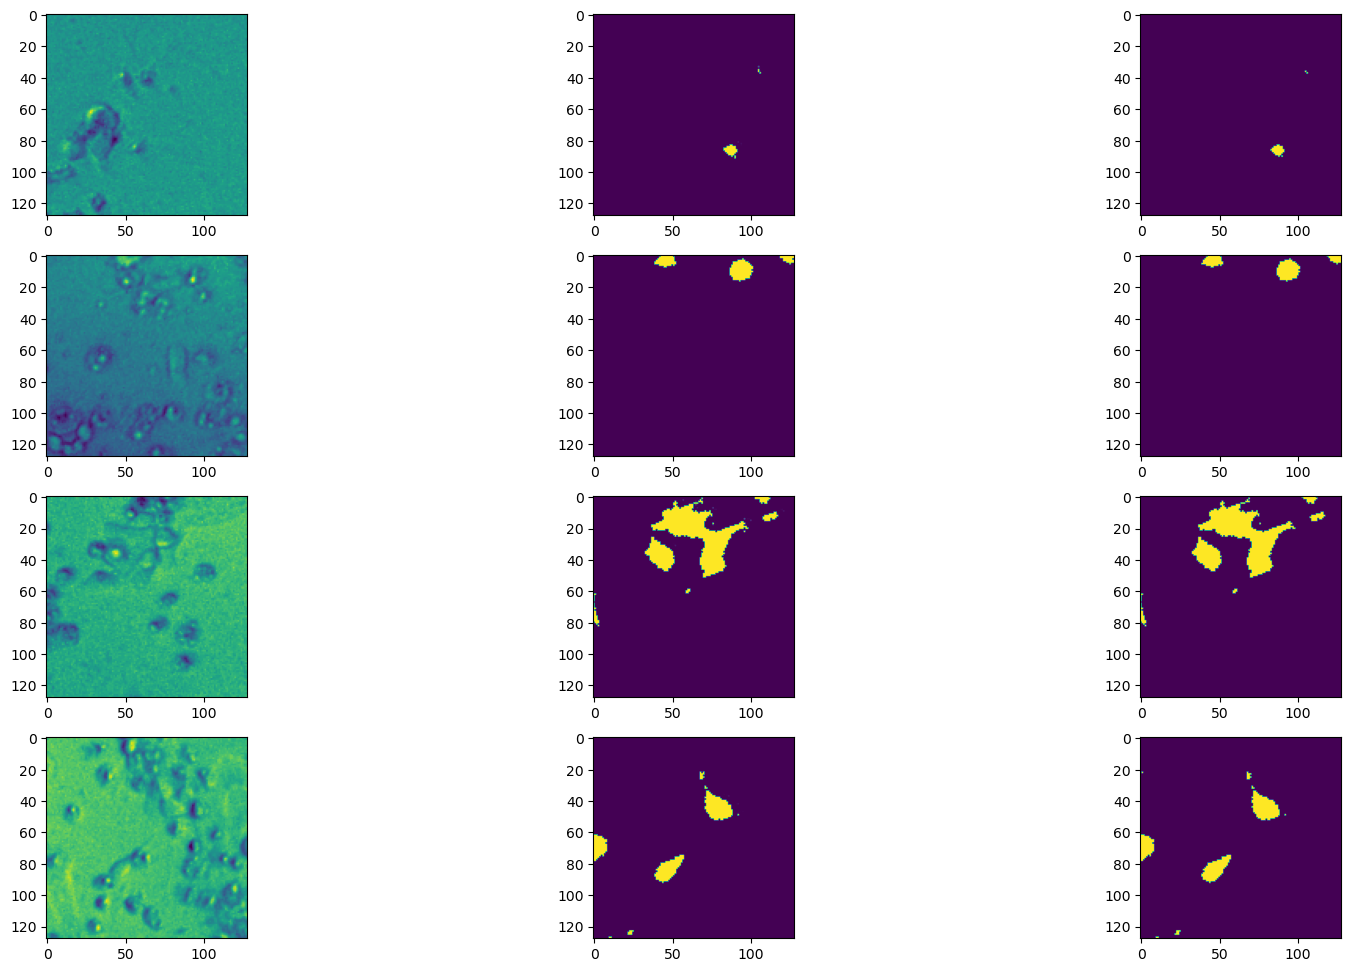

In [111]:
last_batch_dict = torch.load("last_batch_dict.pt")
fig, ax = plt.subplots(nrows = last_batch_dict["data"].shape[0], ncols = 3, figsize = (20, 12))
for i in range(last_batch_dict["data"].shape[0]):
    data = last_batch_dict["data"][i].to("cpu").squeeze()
    pred = last_batch_dict["predictions"][i].to("cpu").squeeze().detach().to(torch.float32).numpy()
    target = last_batch_dict["targets"][i].to("cpu").squeeze()
    ax[i][0].imshow(data)
    ax[i][1].imshow(pred)
    ax[i][2].imshow(target)
plt.show()

In [64]:
pred = last_batch_dict["predictions"][2].to("cpu").squeeze()
target = last_batch_dict["targets"][2].to("cpu").squeeze()

In [71]:
list(pred.unique())

[tensor(0.5000, grad_fn=<UnbindBackward0>),
 tensor(0.5001, grad_fn=<UnbindBackward0>),
 tensor(0.5001, grad_fn=<UnbindBackward0>),
 tensor(0.5002, grad_fn=<UnbindBackward0>),
 tensor(0.5002, grad_fn=<UnbindBackward0>),
 tensor(0.5005, grad_fn=<UnbindBackward0>),
 tensor(0.5005, grad_fn=<UnbindBackward0>),
 tensor(0.5005, grad_fn=<UnbindBackward0>),
 tensor(0.5005, grad_fn=<UnbindBackward0>),
 tensor(0.5006, grad_fn=<UnbindBackward0>),
 tensor(0.5007, grad_fn=<UnbindBackward0>),
 tensor(0.5008, grad_fn=<UnbindBackward0>),
 tensor(0.5008, grad_fn=<UnbindBackward0>),
 tensor(0.5014, grad_fn=<UnbindBackward0>),
 tensor(0.5015, grad_fn=<UnbindBackward0>),
 tensor(0.5016, grad_fn=<UnbindBackward0>),
 tensor(0.5018, grad_fn=<UnbindBackward0>),
 tensor(0.5018, grad_fn=<UnbindBackward0>),
 tensor(0.5018, grad_fn=<UnbindBackward0>),
 tensor(0.5019, grad_fn=<UnbindBackward0>),
 tensor(0.5025, grad_fn=<UnbindBackward0>),
 tensor(0.5031, grad_fn=<UnbindBackward0>),
 tensor(0.5036, grad_fn=<UnbindB

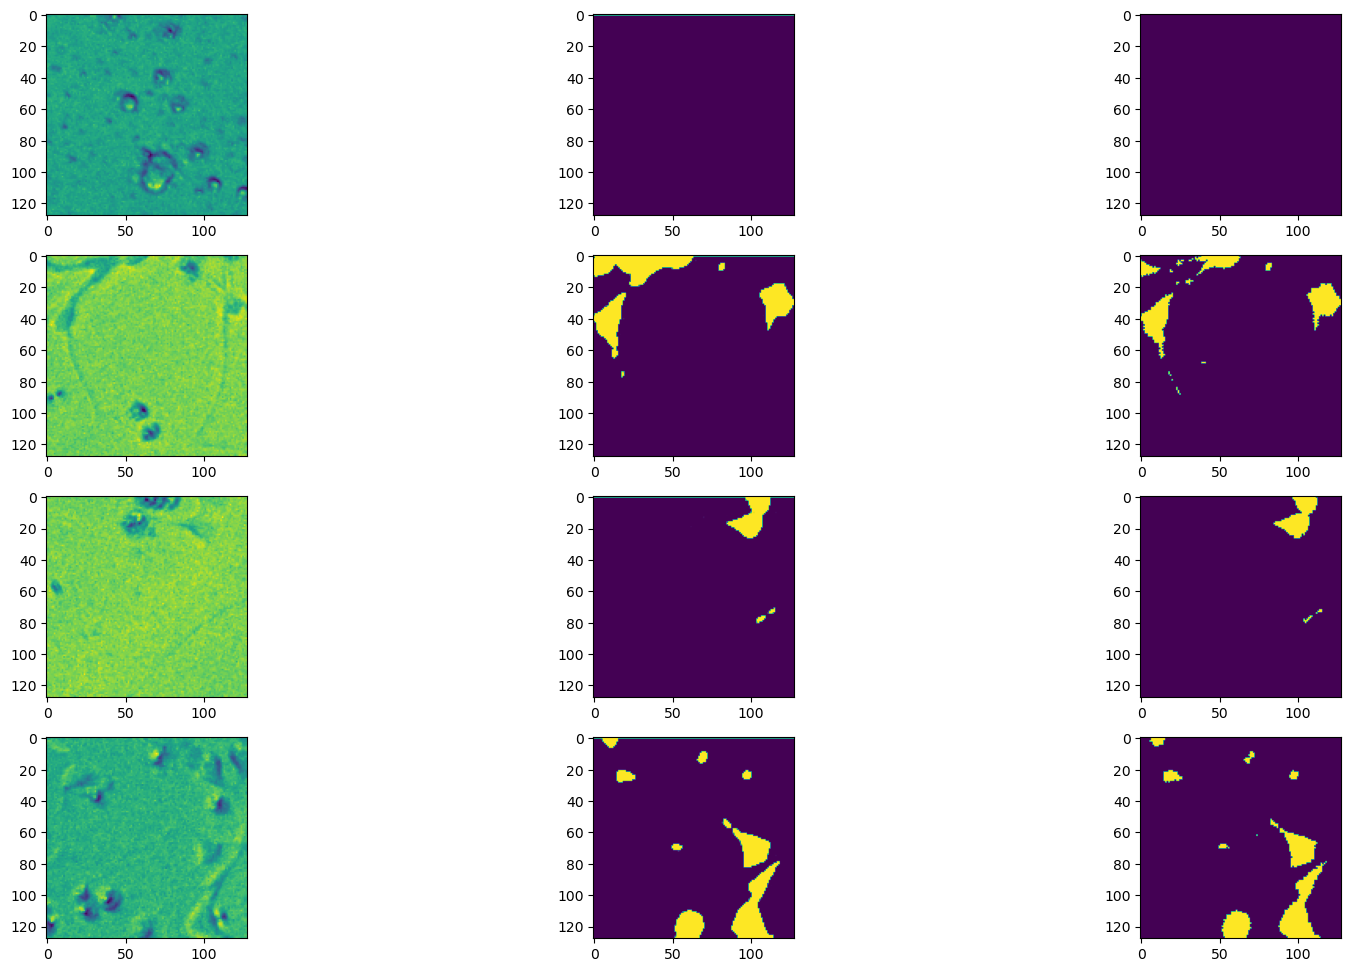

In [173]:
last_batch_dict = torch.load("lbdc.pt")
fig, ax = plt.subplots(nrows = last_batch_dict["data"].shape[0], ncols = 3, figsize = (20, 12))
for i in range(last_batch_dict["data"].shape[0]):
    data = last_batch_dict["data"][i].to("cpu").squeeze()
    pred = last_batch_dict["predictions"][i].to("cpu").squeeze().detach().numpy()
    target = last_batch_dict["targets"][i].to("cpu").squeeze()
    ax[i][0].imshow(data)
    ax[i][1].imshow(pred)
    ax[i][2].imshow(target)
plt.show()

In [150]:
pred = last_batch_dict["predictions"][0].to("cpu").squeeze()
target = last_batch_dict["targets"][0].to("cpu").squeeze()

In [151]:
(pred).unique(return_counts = True)

(tensor([5.7259e-05, 6.0905e-05, 6.8020e-05, 8.1634e-05, 9.0124e-05, 1.1060e-04,
         1.1265e-04, 1.1474e-04, 1.2267e-04, 1.2401e-04, 1.2670e-04, 1.2858e-04,
         1.2921e-04, 1.3194e-04, 1.3225e-04, 1.3421e-04, 1.3751e-04, 1.4166e-04,
         1.4289e-04, 1.5464e-04, 1.5527e-04, 1.5776e-04, 1.6786e-04, 1.6939e-04,
         1.7180e-04, 1.7913e-04, 1.8330e-04, 1.9083e-04, 1.9128e-04, 1.9164e-04,
         1.9282e-04, 1.9868e-04, 2.0428e-04, 2.0983e-04, 2.1438e-04, 2.2443e-04,
         2.2861e-04, 2.3026e-04, 2.3184e-04, 2.3321e-04, 2.4308e-04, 2.5603e-04,
         2.5660e-04, 2.6045e-04, 2.6289e-04, 2.7081e-04, 2.7173e-04, 2.7831e-04,
         2.7952e-04, 2.8604e-04, 2.9306e-04, 2.9927e-04, 2.9995e-04, 3.0215e-04,
         3.0903e-04, 3.1212e-04, 3.2245e-04, 3.2685e-04, 3.2963e-04, 3.4633e-04,
         3.4816e-04, 3.5483e-04, 3.5970e-04, 3.6321e-04, 3.6929e-04, 3.7241e-04,
         3.7500e-04, 3.7965e-04, 3.8023e-04, 3.8894e-04, 3.9134e-04, 3.9171e-04,
         3.9400e-04, 3.9640e

In [152]:
sorted_px = pred.flatten().sort().values.detach()

In [153]:
sorted_px

tensor([5.7259e-05, 6.0905e-05, 6.8020e-05,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00])

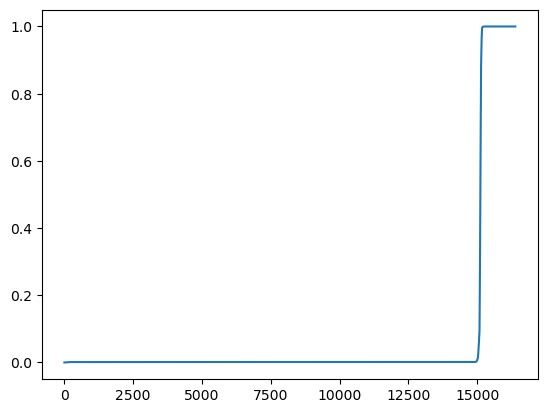

In [154]:
plt.plot(sorted_px)

In [160]:
from model import UNET

In [161]:
model = UNET()

In [164]:
weights = 0
for param in model.parameters():
    weights += param.numel()
print(weights)

31037005


In [167]:
31037005 * 4

124148020